# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [1]:
# Cargar todas las librerías necesarias
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from math import ceil
import seaborn as sns
from scipy import stats as st

## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
# DataFrame de las tarifas
plans = pd.read_csv('/datasets/megaline_plans.csv')

# DataFrame de los usuarios
users = pd.read_csv('/datasets/megaline_users.csv')

#DataFrame de las llamadas
calls = pd.read_csv('/datasets/megaline_calls.csv')

#DastaFrame de los mensajes
messages = pd.read_csv('/datasets/megaline_messages.csv')

#DataFrame del internet
internet = pd.read_csv('/datasets/megaline_internet.csv')

## Preparar los datos

Exploración de los datos de las diferentes tablas para buscar duplicados o valores ausentes

## Tarifas

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
plans.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Imprime una muestra de los datos para las tarifas
display(plans.head())

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


La tabla solo tiene dos renglones , sin valores ausentes y que su tipo de datos está de manera correcta

## Corregir datos

La tabla de las tarifas sólo tiene 2 renglones y no tiene datos ausentes ni datos duplicados. Sin embargo se cambiará la columna de ```mb_per_month_included``` por ```gb_per_month_included``` y se tranformará los mb en gb

In [5]:
plans.rename(columns={'mb_per_month_included': 'gb_per_month_included'}, inplace=True)
plans['gb_per_month_included'] = plans['gb_per_month_included'] / 1024
plans['gb_per_month_included'] = plans['gb_per_month_included'].astype('int')
display(plans.head())

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15,500,20,10,0.03,0.03,surf
1,1000,30,3000,70,7,0.01,0.01,ultimate


## Enriquecer los datos

No es necesario enriquecer los datos porque sólo presenta información del contenido de los 2 distintos planes

## Usuarios/as

In [6]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [7]:
# Imprime una muestra de datos para usuarios
display(users.sample(10))

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
56,1056,Denis,Chandler,33,"Cincinnati, OH-KY-IN MSA",2018-03-01,surf,NaN
241,1241,Lala,Walls,24,"Richmond, VA MSA",2018-08-27,surf,NaN
235,1235,Felton,Nguyen,50,"Minneapolis-St. Paul-Bloomington, MN-WI MSA",2018-02-20,surf,NaN
88,1088,Paris,Robertson,64,"Phoenix-Mesa-Chandler, AZ MSA",2018-05-27,ultimate,NaN
155,1155,Claude,Hahn,19,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-02-21,ultimate,NaN
268,1268,Britni,Bowers,33,"Fresno, CA MSA",2018-01-13,surf,NaN
150,1150,Earlie,Giles,46,"Houston-The Woodlands-Sugar Land, TX MSA",2018-09-19,ultimate,NaN
293,1293,Lanny,Nolan,23,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-08-13,surf,NaN
92,1092,Taren,Strickland,26,"Dallas-Fort Worth-Arlington, TX MSA",2018-12-10,surf,NaN
456,1456,Seymour,Olsen,66,"Minneapolis-St. Paul-Bloomington, MN-WI MSA",2018-06-02,ultimate,NaN


Se observa que solo la columna ```'churm_date``` tiene valores ausentes, esta es una columna que contiene las fechas en las que los usuarios dejaron de usar el servicio. Si se encuentra como ```NaN``` significa que el usuario sigue usando el servicio. Con la información de arriba sabemos que hay 34 usuarios que han dejado de usar el servicio.

### Corregir los datos

Con la información de arriba podemos decir que no hay datos duplicados ya que la muestra quese envío es de 500 usuarios y tenemos exactamente 500 renglones, sin embargo nos aseguraremos de que así sea.

In [8]:
# Buscar renglones duplicados
print(users.duplicated().sum())

0


Como era de esperarse no hay renglones duplicados

### Enriquecer los datos

No es necesario enriquecer los datos porque sólo presenta información de los usuarios

## Llamadas

In [9]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [10]:
# Imprime una muestra de datos para las llamadas
display(calls.sample(10))

,id,user_id,call_date,duration
86978,1320_647,1320,2018-05-16,9.94
79998,1287_47,1287,2018-11-12,2.31
100245,1359_110,1359,2018-02-24,6.27
25794,1099_114,1099,2018-04-23,4.57
77532,1277_608,1277,2018-11-02,3.85
62899,1226_298,1226,2018-08-23,0.00
7577,1036_169,1036,2018-10-19,0.00
74741,1263_725,1263,2018-07-09,17.03
89065,1324_1131,1324,2018-08-02,0.00
22901,1083_263,1083,2018-12-31,9.98


Se observa que no hay datos ausentes en la tabla y los tipos de datos es correcto. Sin embargo se cambiará e tipo de dato de la columna ```'call_date'``` de ```object``` a ```datetime``` para poder acceder posterioirmente a las fechas con mayor facilidad y realizar un mejor análisis. También se buscarán renglones duplicados.

### Corregir los datos

Se va a buscar si hay renglones repetidos y se cambiara el tipo de dato de la columna ```'call_date'```

In [11]:
# Imprime los renglones repetidos
print(calls.duplicated().sum())

0


In [12]:
# Cambai el tipo de datos de la columna call_date
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

In [13]:
# Verifica que el tipo de dato sea correcto
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


### Enriquecer los datos

Se agragará una columna para extraer el mes de la fecha de la llamada para facilitar un futuro análisis

In [14]:
# Agrega la columna call_month
calls['call_month'] = calls['call_date'].dt.month
display(calls.head(5))

,id,user_id,call_date,duration,call_month
0,1000_93,1000,2018-12-27,8.52,12
1,1000_145,1000,2018-12-27,13.66,12
2,1000_247,1000,2018-12-27,14.48,12
3,1000_309,1000,2018-12-28,5.76,12
4,1000_380,1000,2018-12-30,4.22,12


## Mensajes

In [15]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [16]:
# Imprime una muestra de datos para los mensajes
display(messages.sample(10))

,id,user_id,message_date
69991,1454_353,1454,2018-07-28
59934,1381_47,1381,2018-10-22
67771,1439_165,1439,2018-11-04
19291,1124_178,1124,2018-11-17
40593,1261_241,1261,2018-07-19
43375,1287_49,1287,2018-12-13
40115,1259_158,1259,2018-09-01
28419,1174_209,1174,2018-11-15
64286,1408_411,1408,2018-07-29
46996,1320_240,1320,2018-05-31


Se observa que no hay datos ausentes en la tabla y los tipos de datos es correcto. Sin embargo se cambiará e tipo de dato de la columna ```'message_date'``` de ```object``` a ```datetime``` para poder acceder posterioirmente a las fechas con mayor facilidad y realizar un mejor análisis. También se buscarán renglones duplicados.

### Corregir los datos

Se va a buscar si hay renglones repetidos y se cambiara el tipo de dato de la columna ```'message_date'```

In [17]:
# Verifica si hay renglones duplicados
print(messages.duplicated().sum())

0


In [18]:
# Cambia el tipo de dato de la columna message_date
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


### Enriquecer los datos

Se agragará una columna para extraer el mes de la fecha de la llamada para facilitar un futuro análisis

In [19]:
# Agrega la columna message_month que contiene el mes del mensaje
messages['message_month'] = messages['message_date'].dt.month
display(messages.head(5))

,id,user_id,message_date,message_month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


## Internet

In [20]:
# Imprime la información general/resumida sobre el DataFrame de internet
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [21]:
# Imprime una muestra de datos para el tráfico de internet
display(internet.sample(10))

,id,user_id,session_date,mb_used
17264,1077_384,1077,2018-04-23,166.73
33348,1151_90,1151,2018-09-25,788.17
99382,1468_120,1468,2018-10-13,170.46
24015,1110_273,1110,2018-08-10,3.57
49537,1222_36,1222,2018-07-03,0.00
26732,1123_227,1123,2018-07-22,574.05
77395,1362_63,1362,2018-03-24,830.98
4949,1028_523,1028,2018-08-28,474.10
9502,1049_152,1049,2018-10-31,452.47
78936,1368_103,1368,2018-05-23,277.55


Se observa que no hay datos ausentes en la tabla y los tipos de datos es correcto. Sin embargo se cambiará e tipo de dato de la columna ```'session_date'``` de ```object``` a ```datetime``` para poder acceder posterioirmente a las fechas con mayor facilidad y realizar un mejor análisis. También se buscarán renglones duplicados.

### Corregir los datos

Se va a buscar si hay renglones repetidos y se cambiara el tipo de dato de la columna ```'session_date'```

In [22]:
# Buscar renglones repetidos
print(internet.duplicated().sum())

0


In [23]:
# Cambiar el tipo de dato de la columna session_date
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


### Enriquecer los datos

Se agragará una columna para extraer el mes de la fecha de la llamada para facilitar un futuro análisis

In [24]:
# Agrega la columna session_month
internet['session_month'] = internet['session_date'].dt.month
display(internet.head(5))

,id,user_id,session_date,mb_used,session_month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12


## Estudiar las condiciones de las tarifas

Se imprime de nuevo la información de las tarifas para poder ver como funcionan

In [25]:
# Imprime las condiciones del DataFrame plans
display(plans.head())


,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15,500,20,10,0.03,0.03,surf
1,1000,30,3000,70,7,0.01,0.01,ultimate


## Agregar datos por usuario

Se agrupan los datos por usuario y por mes para el número de llamadas, la duración de las llamadas, la cantidad de mensajes, y la cantidad de megas que se consumieron. Esto con el fin de poder saber, por usuario, cuanto consumió de cada servicio por mes.

In [26]:
# Calcula el número de llamadas hechas por cada usuario al mes.
user_calls_by_month = calls.groupby(['user_id', 'call_month'])['user_id'].count()
display(user_calls_by_month.head())

user_id  call_month
1000     12            16
1001     8             27
         9             49
         10            65
         11            64
Name: user_id, dtype: int64

In [27]:
# Calcula la cantidad de minutos usados por cada usuario al mes.
user_calls_minutes_by_month = calls.groupby(['user_id', 'call_month'])['duration'].sum()
print(user_calls_minutes_by_month.head())

user_id  call_month
1000     12            116.83
1001     8             171.14
         9             297.69
         10            374.11
         11            404.59
Name: duration, dtype: float64


In [28]:
# Calcula el número de mensajes enviados por cada usuario al mes.
user_messages_by_month = messages.groupby(['user_id', 'message_month'])['user_id'].count()
print(user_messages_by_month.head())

user_id  message_month
1000     12               11
1001     8                30
         9                44
         10               53
         11               36
Name: user_id, dtype: int64


In [29]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes.
user_mb_by_motnh = internet.groupby(['user_id', 'session_month'])['mb_used'].sum()
print(user_mb_by_motnh.head())

user_id  session_month
1000     12                1901.47
1001     8                 6919.15
         9                13314.82
         10               22330.49
         11               18504.30
Name: mb_used, dtype: float64


El siguiente código junta los datos anteriores en un DataFrame para tener toda la informción junta. Además también se quitarán los datos ausentes que aparezcan debido a la concatenación, estos valores se cambiaran a 0, se decide cambiar a 0 porque el valor ausente representa que el usuario, en el mes correspondiente, no hizo ninguna llamada, no mandó ningún mensaje o no consumio megas de internet.

In [30]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
users_info = pd.concat([user_calls_by_month, user_calls_minutes_by_month, user_messages_by_month, user_mb_by_motnh], axis = 1)
display(users_info.head())

user_id  duration  user_id   mb_used
user_id                                         
1000    12     16.0    116.83     11.0   1901.47
1001    8      27.0    171.14     30.0   6919.15
        9      49.0    297.69     44.0  13314.82
        10     65.0    374.11     53.0  22330.49
        11     64.0    404.59     36.0  18504.30

Cómo se puede observar, los datos ya están en un solo DataFrame, sin embargo, aún queda corregirlo un poco para facilitar su uso. Se cambiarán los nombres de las columnas por unos más representativos y se pondrá un nombre a al índice que corresponde al mes. También se cambiarán los valores ausentes a 0 como ya se había explicado y se cambiará el tipo de datos de las columnas que contienen el número de llamdas y número de mensajes por un tipo ```ìnt```.

In [31]:
# Cambia las columnas de nombre
users_info.columns = ['number_of_calls', 'calls_duration', 'number_of_messages', 'mb_used']

# Pone nombre al índice del mes
users_info = users_info.rename_axis(index={users_info.index.names[1]: 'month'})

# Cambia los valores ausentes por 0
users_info.fillna(0, inplace=True)

# Cambia el tipo de dato de las columnas number_of_calls y number_of_messages
users_info['number_of_calls'] = users_info['number_of_calls'].astype('int')
users_info['number_of_messages'] = users_info['number_of_messages'].astype('int')

display(users_info.head())

number_of_calls  calls_duration  number_of_messages   mb_used
user_id month                                                               
1000    12                  16          116.83                  11   1901.47
1001    8                   27          171.14                  30   6919.15
        9                   49          297.69                  44  13314.82
        10                  65          374.11                  53  22330.49
        11                  64          404.59                  36  18504.30

Como se puede observar nuestro DataFrame ya se encuentra más detallado y entendible.

Ahora cambiaré el índice de 2 niveles a que sean sólo columnas, de esta forma me resulta más sencillo trabajar, ya que no tengo
mucha experiencia trabajando con un índice de múltiples niveles.

De igual manera, se usará un mapeo para agregar una nueva columna a nuestro DataFrame que contenga el tipo de plan que el
usuario esté usando.

In [32]:
#Convierte user_id y month en columnas
users_info = users_info.reset_index(level=['user_id','month'])

# Añade la información del tipo de plan utilizando el mapeo
mapeo = dict(zip(users['user_id'], users['plan']))
users_info['plan'] = users_info['user_id'].map(mapeo)

display(users_info.head())

,user_id,month,number_of_calls,calls_duration,number_of_messages,mb_used,plan
0,1000,12,16,116.83,11,1901.47,ultimate
1,1001,8,27,171.14,30,6919.15,surf
2,1001,9,49,297.69,44,13314.82,surf
3,1001,10,65,374.11,53,22330.49,surf
4,1001,11,64,404.59,36,18504.30,surf


Nuestro DataFrame ya está casi listo para poder utilizarlo en un análisis, ahora usaré la información de la columna ```plan```, que se acaba de agregar para poder incluir toda la información del tipo de plan, está se sacará de la tabla llamada plans.

In [33]:
# Agrega toda la información de acuerdo al plan que tiene el usuario
users_info = users_info.merge(plans, left_on='plan', right_on='plan_name')

# Borra la columna repetida que se crea por la función merge
users_info = users_info.drop('plan_name', axis='columns')
display(users_info.head())

,user_id,month,number_of_calls,calls_duration,number_of_messages,mb_used,plan,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1000,12,16,116.83,11,1901.47,ultimate,1000,30,3000,70,7,0.01,0.01
1,1006,11,2,9.32,15,2068.37,ultimate,1000,30,3000,70,7,0.01,0.01
2,1006,12,9,54.79,139,32118.82,ultimate,1000,30,3000,70,7,0.01,0.01
3,1008,10,71,450.21,21,17106.99,ultimate,1000,30,3000,70,7,0.01,0.01
4,1008,11,63,422.81,37,23676.72,ultimate,1000,30,3000,70,7,0.01,0.01


A continuación se calculan las tarifas extras causadas por sobrepasar el límite de minutos de las llamadas, el límite de la cantidad de mensajes y el límite de la cantidad de mb consumidos. Estas tarifas extras sumadas al pago mensual de cada plan nos dará el total de lo que los usuarios gastaron por mes.

Para esto utilizaré funciones y despues se agregará la columna con la información correspondiente al servicio que sobrepaso el límite. Cada servicio tiene sus reglas que aplican cuando el usuario se excede del límite, la información recién agregada ya contiene el precio que se aplica, dichas reglas son mencionadas a continuación:

* Para los mensajes extra, dependiendo el plan, cada mensaje extra se multiplica por una tarifa específica.

* GB excedidos: por cada GB extra, se aplica una tarifa dada de acuerdo al plan. La información de nuestra tabla tiene el consumo de internet en MB, por lo que es necesario transformar este dato en GB, además, si e resultado de está conversión es un número decimal se va a redondear al siguiente entero para cobrar GB completos, ya que así lo marca la regla.

* Minutos de llamadas: Por cada minuto se aplica una tarifa que está marcada de acuerdo al tipo de plan. Para este calculo de igual manera, si los minutos tienen decimales se redondeará al siguiente entero para poder cobrar minutos completos. 

In [34]:
# Función para calcular la tarifa extra de los mensajes, si no excedió el límite retorna un 0
def extra_messages(row):
    # Diferencia en el número de mensajes. Si es menor a 0, significa que no se excedió en el límite dado. Si es mayor que 0 si
    # se excedió
    messages_dif = row['number_of_messages'] - row['messages_included']
    
    # Verifica si la diferencia de mensajes es mayor que 0
    if messages_dif > 0:
        # Aplica el cargo por mensaje extra
        return messages_dif * row['usd_per_message']
    else:
        return 0
    
# Función para calcular la tarifa extra de los gb, si no excedió el límite retorna un 0
def extra_gb(row):
    # Convierte los mb excendentes en gigas
    gb = row['mb_used'] / 1024
    
    # Redondea los gigas al numero entero siguiente 
    gb = np.ceil(gb)
    
    # Diferencia los mb usados y los mb límite. Si es menor a 0, significa que no se excedió en el límite dado. Si es mayor que
    # 0 si se excedió
    gb_dif = gb - row['gb_per_month_included']
    
     # Verifica si la diferencia de mensajes es mayor que 0
    if gb_dif > 0:
        return gb_dif * row['usd_per_gb']
    else:
        return 0

# Función para calcular la tarifa extra de los minutos, si no excedió el límite retorna un 0
def extra_min(row):
    min_dif = np.ceil(row['calls_duration'])
    min_dif -= row['minutes_included']
    if min_dif > 0:
        return min_dif * row['usd_per_minute']
    else:
        return 0

# Agrega la columna con el valor de la tarifa extra de los mensajes.
users_info['usd_extra_messages'] = users_info.apply(extra_messages, axis=1)

# Agrega la columna con el valor de la tarifa extra de los mb.
users_info['usd_extra_gb'] = users_info.apply(extra_gb, axis=1)

# Agrega la columna con el valor de la tarifa extra de los minutos de llamadas.
users_info['usd_extra_min'] = users_info.apply(extra_min, axis=1)

# Agrega la columna con el valor de la tarifa TOTAL que tiene que pagar cada usuario, sumando el pago mensual de cada mes y
# la tarifa extra que haya tenido en cada servicio, si es que tuvo.
users_info['total_monthly_pay'] = users_info['usd_monthly_pay'] + users_info['usd_extra_messages'] + users_info['usd_extra_gb'] + users_info['usd_extra_min']

In [36]:
display(users_info.sample(5))

,user_id,month,number_of_calls,calls_duration,number_of_messages,mb_used,plan,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,usd_extra_messages,usd_extra_gb,usd_extra_min,total_monthly_pay
1790,1328,7,132,850.55,164,36408.26,surf,50,15,500,20,10,0.03,0.03,3.42,210.0,10.53,243.95
1724,1313,8,85,668.37,61,16293.62,surf,50,15,500,20,10,0.03,0.03,0.33,10.0,5.07,35.40
2145,1439,10,40,294.26,77,17702.60,surf,50,15,500,20,10,0.03,0.03,0.81,30.0,0.00,50.81
745,1009,7,124,826.74,0,30421.65,surf,50,15,500,20,10,0.03,0.03,0.00,150.0,9.81,179.81
539,1401,8,10,74.66,13,630.23,ultimate,1000,30,3000,70,7,0.01,0.01,0.00,0.0,0.00,70.00


## Estudia el comportamiento de usuario

Se calculan algunas estadísticas descriptivas para los datos agregados y fusionados que nos sean útiles y que muestren un panorama general captado por los datos. Además se crean gráficos útiles para facilitar la comprensión.

### Llamadas

Se grafica la duración del promedio de duración de las llamdas de cada plan, de esta forma podremos comparar la cantidad promedio de minutos que usan los usuarios en cada mes.

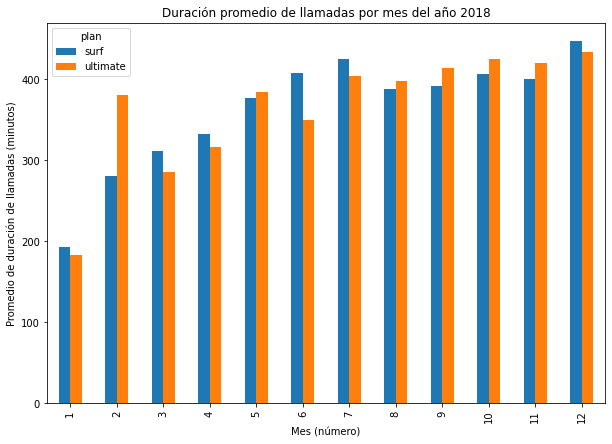

In [37]:
# Agrupamos el DataFrame users_info por mes y por plan y después se saca el promedio de la duración de las llamadas
duration_mean = users_info.groupby(['month','plan'])['calls_duration'].mean().unstack()

# Grafica la información obtenida arriba
duration_mean.plot(kind='bar', figsize=(10,7), title='Duración promedio de llamadas por mes del año 2018', xlabel='Mes (número)',
                  ylabel='Promedio de duración de llamadas (minutos)')

plt.show()

<span style="color: blue;">Conclusiones:</span>

La mayor cantidad de minutos usados en son en los últimos  meses, siendo diciembre el mes con más minutos usados. También podemos obvesrvar que no es mucha la diferencia en los promedios de duración de llamdas en cada plan, la mayor diferencia la podemos observar en el mes de febrero que son aproximadamente 100 minutos.

Son pocos los meses que el plan surf supera el promedio de los 400 minutos, se puede decir que en estos meses (julio-diciembre)  hay más personas que en este plan que superaron su límite de 500 minutos.

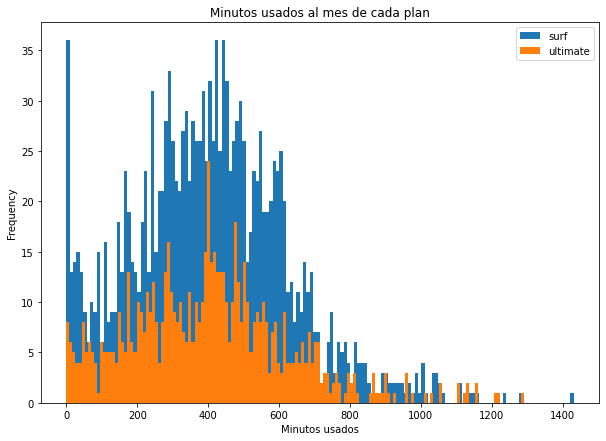

In [38]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan.
users_info[users_info['plan']=='surf']['calls_duration'].plot(kind='hist', bins=150, figsize=(10,7),
                                                title='Minutos usados al mes de cada plan',label='surf')
users_info[users_info['plan']=='ultimate']['calls_duration'].plot(kind='hist', bins=150, label='ultimate')
plt.legend()
plt.xlabel('Minutos usados')
plt.show()

<span style="color: blue;">Conclusiones:</span>

Con este histograma podemos decir que el plan surf es más utilizado por los usuarios. Aunque se ve que hay demasiados usuarios que sobrepasan el límite mensual que tiene el plan ya que pasando los 500 minutos y llegando a los 600 minutos hay una frecuancia de 15 o más.

In [39]:
# Calcula la media y la varianza de la duración mensual de llamadas.
# Plan surf
surf_call_duration_mean = users_info[users_info['plan']=='surf']['calls_duration'].mean()
surf_call_duration_var = np.var(users_info[users_info['plan']=='surf']['calls_duration'])

# Plan ultimate
ultimate_call_duration_mean = users_info[users_info['plan']=='ultimate']['calls_duration'].mean()
ultimate_call_duration_var = np.var(users_info[users_info['plan']=='ultimate']['calls_duration'])

print('La media de la duración de las llamdas del plan surf es de:', surf_call_duration_mean)
print('La varianza de la duración de las llamadas del plan surf es de:' , surf_call_duration_var)
print('La media de la duración de las llamdas del plan ultimate es de:', ultimate_call_duration_mean)
print('La varianza de la duración de las llamadas del plan ultimate es de:' , ultimate_call_duration_var)

La media de la duración de las llamdas del plan surf es de: 404.76239033693577
La varianza de la duración de las llamadas del plan surf es de: 49103.8683332564
La media de la duración de las llamdas del plan ultimate es de: 406.1930833333333
La varianza de la duración de las llamadas del plan ultimate es de: 51569.24783077083


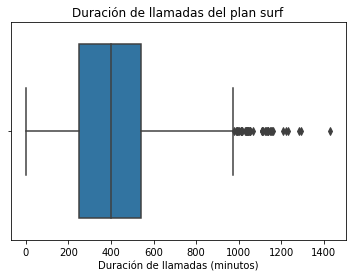

In [40]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
sns.boxplot(x=users_info['calls_duration'], data=users_info[users_info['plan']=='surf'])
plt.xlabel('Duración de llamadas (minutos)')
plt.title('Duración de llamadas del plan surf')

plt.show()

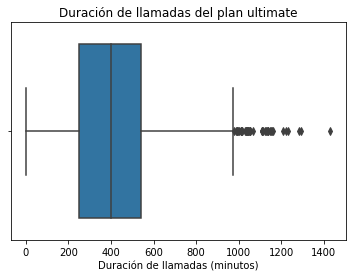

In [41]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
sns.boxplot(x=users_info['calls_duration'], data=users_info[users_info['plan']=='ultimate'])
plt.xlabel('Duración de llamadas (minutos)')
plt.title('Duración de llamadas del plan ultimate')

plt.show()

<span style="color: blue;">Conclusiones:</span>

Con este análisis comprobamos que la media de duración de llamdas en ambos planes se encuentra muy cerca de los 400 minutos, el intervalo intercuartil se encuentra entre los 200 y 400. Es decir, el 50% de los usuarios tienen de 200 a 400 minutos mensuales de llamdas, independientemente cual sea el plan que tengan. 

### Mensajes

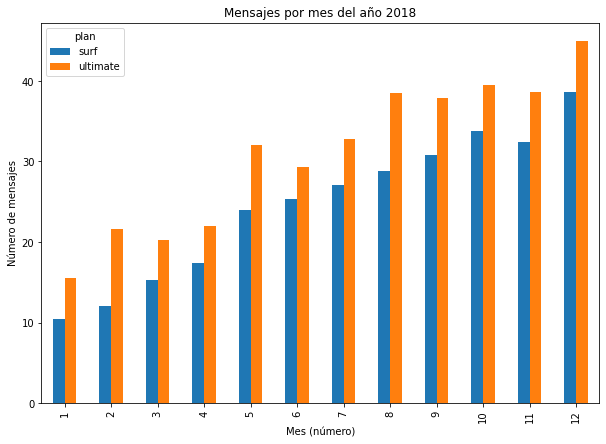

In [42]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
duration_mean_messages = users_info.groupby(['month','plan'])['number_of_messages'].mean().unstack()
duration_mean_messages.plot(kind='bar', figsize=(10,7), title='Mensajes por mes del año 2018', xlabel='Mes (número)',
                  ylabel='Número de mensajes')

plt.show()

<span style="color: blue;">Conclusiones:</span>

La mayor cantidad de mensajes enviados se da en los últimos  meses, siendo diciembre el mes con más mensajes teniendo un promedio casi 40 mesajes enviados para el plan surf y un promedio de 50 mensajes para el plan ultimate. También podemos obvesrvar que no es mucha la diferencia en los promedios mensajes enviados en cada plan.

En promedio, ningún plan supera sus límites que tienen. Sin embargo para el plan surf, mientras el promedio esté más cerc de 40 se puede decir que hay usuarios que si superaron su límite de 50 mensajes.

El comportamiento que presenta es muy parecido al que se presenta para los minutos usados de llamdas.

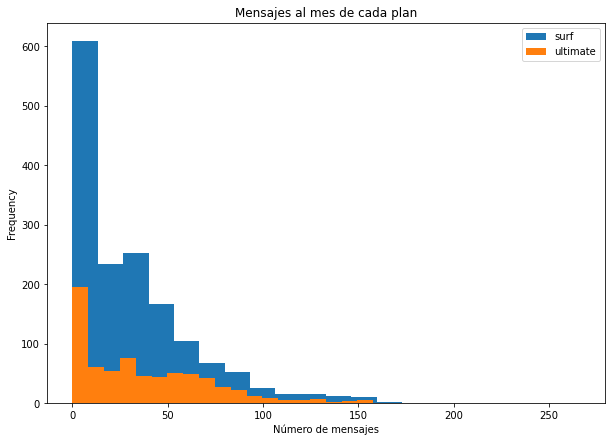

In [43]:
# Compara la cantidad de mensajes mensuales que necesitan los usuarios de cada plan.
users_info[users_info['plan']=='surf']['number_of_messages'].plot(kind='hist', bins=20, figsize=(10,7),
                                                title='Mensajes al mes de cada plan',label='surf')
users_info[users_info['plan']=='ultimate']['number_of_messages'].plot(kind='hist', bins=20, label='ultimate')
plt.legend()
plt.xlabel('Número de mensajes')
plt.show()


<span style="color: blue;">Conclusiones:</span>

Con este histograma podemos decir que el plan surf sigue siendo el más utilizado por los usuarios. y se observa que siguen siendo muchos los usuarios que sobrepasan el límite mensual que tiene el plan (50 mensajes). Los usuarios del plan surf sobrepasan más veces el límite que tiene el plan para mnsajes y para minutos de llamadas.

In [44]:
# Calcula la media y la varianza de la cantidad de mensajes enviados en cada plan.
surf_messages_mean = users_info[users_info['plan']=='surf']['number_of_messages'].mean()
surf_messages_var = np.var(users_info[users_info['plan']=='surf']['number_of_messages'])


ultimate_messages_duration_mean = users_info[users_info['plan']=='ultimate']['number_of_messages'].mean()
ultimate_messages_duration_var = np.var(users_info[users_info['plan']=='ultimate']['number_of_messages'])

print('La media del número de mensajes del plan surf es de:', surf_messages_mean)
print('La varianza del número de mensajes del plan surf es de:' , surf_messages_var)
print('La media del número de mensajes del plan ultimate es de:', ultimate_messages_duration_mean)
print('La varianza del número de mensajes del plan ultimate es de:' , ultimate_messages_duration_var)

La media del número de mensajes del plan surf es de: 31.15956770502225
La varianza del número de mensajes del plan surf es de: 1126.0082317266622
La media del número de mensajes del plan ultimate es de: 37.55138888888889
La varianza del número de mensajes del plan ultimate es de: 1207.0779147376543


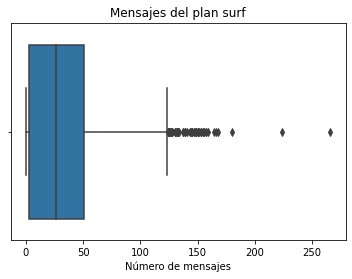

In [45]:
sns.boxplot(x=users_info['number_of_messages'], data=users_info[users_info['plan']=='surf'])
plt.xlabel('Número de mensajes')
plt.title('Mensajes del plan surf')

plt.show()

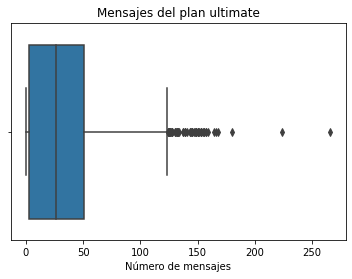

In [46]:
sns.boxplot(x=users_info['number_of_messages'], data=users_info[users_info['plan']=='ultimate'])
plt.xlabel('Número de mensajes')
plt.title('Mensajes del plan ultimate')

plt.show()

<span style="color: blue;">Conclusiones:</span>

Con este análisis comprobamos que la media de mensajes enviados en ambos planes se encuentra muy cerca de los 50 mensajes, no hay variación entre un plan y otro, el intervalo intercuartil se encuentra entre 1 y un poco más de 50 mensajes. Es decir, el 50% de los usuarios tienen de 1 a 50 mensajes enviados mensuales, independientemente cual sea el plan que tengan.

Este comportamiento sigue siendo muy similiar para la duración de las llamadas.

### Internet

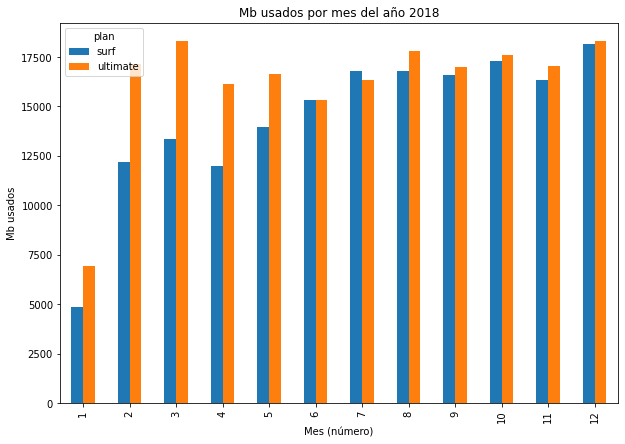

In [47]:
# Comprara los mb consumidos por los usuarios de cada plan
duration_mean_mb = users_info.groupby(['month','plan'])['mb_used'].mean().unstack()
duration_mean_mb.plot(kind='bar', figsize=(10,7), title='Mb usados por mes del año 2018', xlabel='Mes (número)',
                  ylabel='Mb usados')

plt.show()

<span style="color: blue;">Conclusiones:</span>

Aquí podemos ver que el promedio de los mb utilizados en el plan ultimate se encuentra entre los 15000 mb y los 17500 mb a partir del mes de febrero. En el plan surf el consumo va creciendo gradualmente conforme pasan los meses. Es de junio en adelante que la diferencia en el promedio del consumo de mb entre los planes no presenta mucha diferencia.

A partir del mes de junio el promedio de mb usados del plan surf, está por encima de los 15000 mb, el cuál es el límite de mb para este plan. Con esto podemos decir que una gran mayoria de usuarios superó su límite de mb.

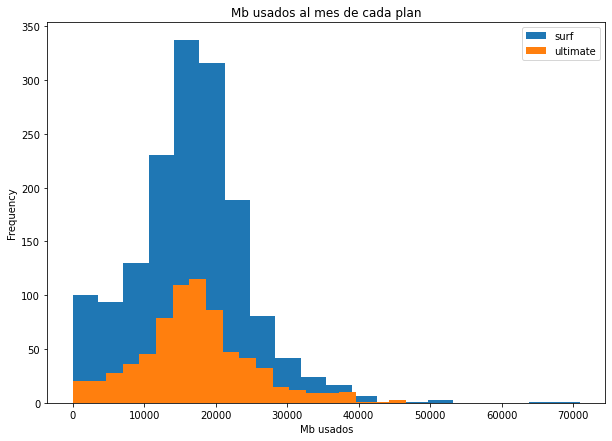

In [48]:
# Compara elos mb consumidos mensuales que necesitan los usuarios de cada plan.
users_info[users_info['plan']=='surf']['mb_used'].plot(kind='hist', bins=20, figsize=(10,7),
                                                title='Mb usados al mes de cada plan',label='surf')
users_info[users_info['plan']=='ultimate']['mb_used'].plot(kind='hist', bins=20, label='ultimate')
plt.legend()
plt.xlabel('Mb usados')
plt.show()


<span style="color: blue;">Conclusiones:</span>

En este histograma podemos decir que de nuevo el plan surf sigue siendo el más utilizado por los usuarios. Y se observa que, de igaul manera, siguen siendo muchos los usuarios que sobrepasan el límite mensual que tiene el plan (15000 mb). Los usuarios del plan surf sobrepasan más veces el límite que tiene el plan para mnsajes y para minutos de llamadas.

In [49]:
# Calcula la media y la varianza de los mb usados.
surf_mb_mean = users_info[users_info['plan']=='surf']['mb_used'].mean()
surf_mb_var = np.var(users_info[users_info['plan']=='surf']['mb_used'])

ultimate_mb_mean = users_info[users_info['plan']=='ultimate']['mb_used'].mean()
ultimate_mb_var = np.var(users_info[users_info['plan']=='ultimate']['mb_used'])

print('La media de los mb consumidos del plan surf es de:', surf_mb_mean)
print('La varianza de los mb consumidos del plan surf es de:' , surf_mb_var)
print('La media de los mb consumidos del plan ultimate es de:', ultimate_mb_mean)
print('La varianza de los mb consumidos del plan ultimate es de:' , ultimate_mb_var)

La media de los mb consumidos del plan surf es de: 16558.283490146216
La varianza de los mb consumidos del plan surf es de: 64175571.68301331
La media de los mb consumidos del plan ultimate es de: 17214.699694444444
La varianza de los mb consumidos del plan ultimate es de: 61566665.1386863


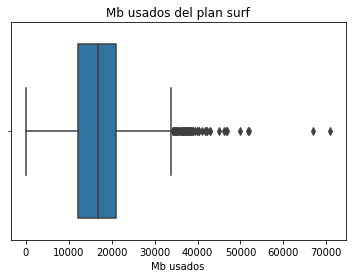

In [50]:
# Crea un boxplot de los mb usados por los usuarios del plan surf
sns.boxplot(x=users_info['mb_used'], data=users_info[users_info['plan']=='surf'])
plt.xlabel('Mb usados')
plt.title('Mb usados del plan surf')

plt.show()

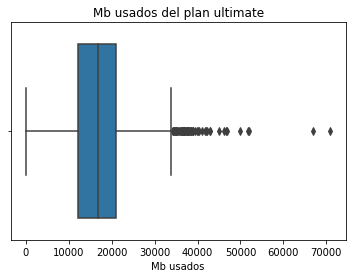

In [51]:
# Crea un bosplot de los mb usados por los usuarios del plan ultimate
sns.boxplot(x=users_info['mb_used'], data=users_info[users_info['plan']=='ultimate'])
plt.xlabel('Mb usados')
plt.title('Mb usados del plan ultimate')

plt.show()

<span style="color: blue;">Conclusiones:</span>

Con este análisis comprobamos que la media de mb usados en el plan surf es de  16558 y en el plan ultimate es de 17214, no hay una gran variación entre un plan y otro ya que sólo hay 1 gb de diferencia. El intervalo intercuartil se encuentra entre los 10000 y un poco más de 20000 mb. Es decir, el 50% de los usuarios tienen de 10000 a 20000 mb usados mensualmente, independientemente cual sea el plan que tengan.

Este comportamiento sigue siendo muy similiar para la duración de las llamadas y mensajes.

## Ingreso

[Del mismo modo que has estudiado el comportamiento de los usuarios, describe estadísticamente los ingresos de los planes.]

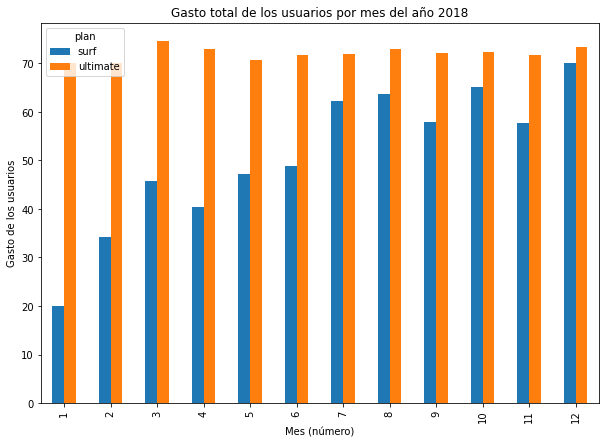

In [52]:
# Comprara el ingreso total proveniente de los usuarios de cada plan
duration_mean_mb = users_info.groupby(['month','plan'])['total_monthly_pay'].mean().unstack()
duration_mean_mb.plot(kind='bar', figsize=(10,7), title='Gasto total de los usuarios por mes del año 2018', xlabel='Mes (número)',
                  ylabel='Gasto de los usuarios')

plt.show()

<span style="color: blue;">Conclusiones:</span>

El promedio de ingreso para el plan ultimate se mantiene un poco arriba de los 70 usd durante todo el año, el cual es su precio mensual. Por otra parte, se aprecia que el gasto que hacen los usuarios del plan surf va aumentando gradualmente hasta que en diciembre casi llega a los 70 usd, siendo que este plan cuesta 20 usd. Es decir, en cada mes que pasa los usuarios del plan surf van sobrepasando más el límite de algun servicio, ya sea de minutos, mensajes o mb.

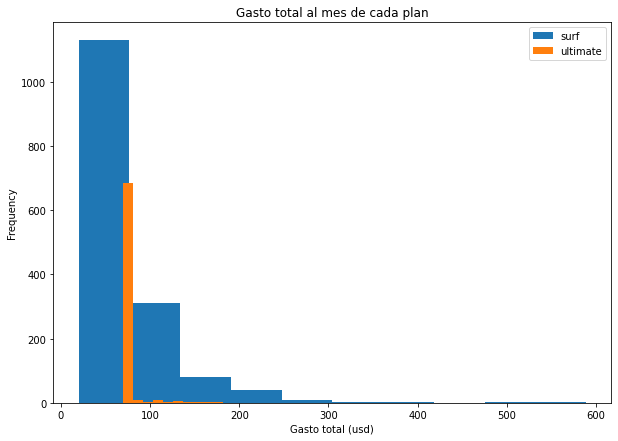

In [53]:
# Compara elingreso total mensual que necesitan los usuarios de cada plan.
users_info[users_info['plan']=='surf']['total_monthly_pay'].plot(kind='hist', bins=10, figsize=(10,7),
                                                title='Gasto total al mes de cada plan',label='surf')
users_info[users_info['plan']=='ultimate']['total_monthly_pay'].plot(kind='hist', bins=10, label='ultimate')
plt.legend()
plt.xlabel('Gasto total (usd)')
plt.show()

<span style="color: blue;">Conclusiones:</span>

El plan en el que más gastan los usuarios es el surf, ya que a pesar de que su costo es de 20 usd, en más de 1000 ocaciones los usuarios han tenido que pagar entre 70 y 80. Mientras que para el plan ultimate es apreciable que la mayoría de sus usuarios pagan solamente lo que el plan cuesta al mes.

In [54]:
# Calcula la media y la varianza de los ingresos totales.
surf_pay_mean = users_info[users_info['plan']=='surf']['total_monthly_pay'].mean()
surf_pay_var = np.var(users_info[users_info['plan']=='surf']['total_monthly_pay'])

ultimate_pay_mean = users_info[users_info['plan']=='ultimate']['total_monthly_pay'].mean()
ultimate_pay_var = np.var(users_info[users_info['plan']=='ultimate']['total_monthly_pay'])

print('La media de los ingresos totales del plan surf es de:', surf_pay_mean)
print('La varianza de los ingresos totales del plan surf es de:' , surf_pay_var)
print('La media de los ingresos totales del plan ultimate es de:', ultimate_pay_mean)
print('La varianza de los ingresos totales del plan ultimate es de:' , ultimate_pay_var)

La media de los ingresos totales del plan surf es de: 60.331932612841705
La varianza de los ingresos totales del plan surf es de: 3052.155930912179
La media de los ingresos totales del plan ultimate es de: 72.31388888888888
La varianza de los ingresos totales del plan ultimate es de: 129.66814043209877


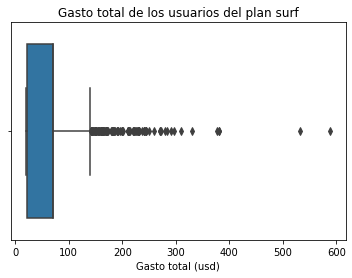

In [55]:
sns.boxplot(x=users_info['total_monthly_pay'], data=users_info[users_info['plan']=='surf'])
plt.xlabel('Gasto total (usd)')
plt.title('Gasto total de los usuarios del plan surf')

plt.show()

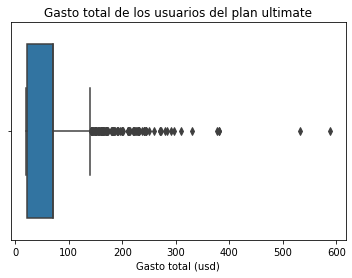

In [56]:
sns.boxplot(x=users_info['total_monthly_pay'], data=users_info[users_info['plan']=='ultimate'])
plt.xlabel('Gasto total (usd)')
plt.title('Gasto total de los usuarios del plan ultimate')

plt.show()

<span style="color: blue;">Conclusiones:</span>

Podemos ver que a pesar de que el plan surf es más barato que el plan ultimate, en realidad no hay gran variedad en el gasto total que hacen los usuarios. Esto debido a que los usuarios  del plan surf superan en mayor medida sus límites de cada servicio provocando que se carguen tarifas adicionales al costo mensual.

## Prueba las hipótesis estadísticas

Prueba la hipótesis de que son diferentes los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf.

Hipótesis nula: los ingresos promedio del plan surf son iguales a los ingresos promedio del plan ultimate.

Hipótesis alternativa: los ingresos promedio del plan surf son diferentes que los ingresos promedio del plan ultimate.

El valor alpha se establece en 5% y establecemos ```equal_var=False``` porque sabemos, del ejercicio anterior que las varianas no son nada parecidas.

In [57]:
# Primero sacamos los dos arrays de nuestro DataFrame
# Array que contiene los ingresos provenientes del plan surf
surf_payment = users_info.loc[users_info['plan']=='surf', 'total_monthly_pay']

# Array que contiene los ingresos provenientes del plan ultimate
ultimate_payment = users_info.loc[users_info['plan']=='ultimate', 'total_monthly_pay']

# Prueba las hipótesis
alpha = 0.05

results = st.ttest_ind(surf_payment, ultimate_payment, equal_var=False)
print('valor p:', results.pvalue)

if results.pvalue <  alpha:
    print('Rechazamos la hipótesis nula')
else:
    prnt('No podemos rechazar la hipótesis nula')

valor p: 3.6278039040985444e-16
Rechazamos la hipótesis nula


<span style="color: blue;">Conclusiones:</span>

Al tener un valor p demasiado bajo, nuestro análisis sugiere que los ingresos difieren de un plan a otro

Prueba la hipótesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.

Hipótesis nula: los ingresos promedio de los usuarios del área de NY-NJ son iguales a los ingresos promedio de los usuarios de otras regiones.

Hipótesis alternativa: los ingresos promedio del área de NY-NJ son diferentes que los ingresos promedio de los usuarios de otras regiones.

El valor alpha se establece en 5%, establecemos ```equal_var=True``` porque no sabemos como son las varianzas de estos datos.

In [58]:
# Agregamos una columna a nuestro DF que contiene la ciudad de donde es cada usuario New York-Newark-Jersey City, NY-NJ-PA MSA
mapeo = dict(zip(users['user_id'], users['city']))
users_info['city'] = users_info['user_id'].map(mapeo)

# Array que contiene los ingresos provenientes de los usuarios de NY-NJ
NY_NJ_users = users_info.loc[users_info['city']=='New York-Newark-Jersey City, NY-NJ-PA MSA', 'total_monthly_pay']

# Array que contiene los ingresos provenientes del plan ultimate
other_users = users_info.loc[~(users_info['city']=='New York-Newark-Jersey City, NY-NJ-PA MSA'), 'total_monthly_pay']

# Prueba las hipótesis
alpha = 0.05

results = st.ttest_ind(NY_NJ_users, other_users, equal_var=True)
print('valor p:', results.pvalue)

if results.pvalue <  alpha:
    print('Rechazamos la hipótesis nula')
else:
    prnt('No podemos rechazar la hipótesis nula')


valor p: 0.04076784279879048
Rechazamos la hipótesis nula


<span style="color: blue;">Conclusiones:</span>

Los datos proporcionan evidencia sufuciente, dado el nivel de significación que seleccionamos, para rechazar la hipótesis. Nuestro análisis sugiere que los ingresos difieren de la región de NY-NJ a otra región diferente a esa

## Conclusión general



Este fue un excelente proyecto que ya recopila más temas vistos e el BootCamp. Me gustó mucho y también me gusta que ya no sea tan guiado, debí tomar mis propias decisiones para saber como abordar los retos